# Facies discrimination using elemental intensities (design the workflow)
Let's adopt the elemental dataset which having the rolling trick to run the gridsearch using server.

In [1]:
import numpy as np 
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
#mpl.rcParams['xtick.labelsize'] = 8
#mpl.rcParams["image.cmap"] = 'gray'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

# Run ML: Logistic regression
After a struggling of try and error, I conclude several points. Since this rolling trick needs a costomized spliting function, which I wrote myself, the dask has problem of optimize the paralellism with GridsearchCV. No matter using interactive job (dask.jobqueue) or manual sbatch submition, the workers failed at certain parameter C. Below I have two parts. First is the gridsearch results that the worker aren't killed using dask.jobqueue. Second is the gridsearch results using manual submistion that no dask involved at all. The python and submition scripts are named "grid_lr.py" and "submit_lr.sh". The trials, mostly unsuccessful are named mess_01.ipynb, mess_02.ipynb, grid_lr_dask_mpi.py, and submit_lr_mpi.sh in the folder "others".

## Prepare data
I have tried also implementing dask.dataframe and dask.array, but they all have problem with my costomized split function.

In [7]:
from split import my_train_test_split
data_df = pd.read_csv('data/XRF_ML_cr.csv')
X = data_df.iloc[:, 1:-2].values
y = data_df['facies_merge_1'].values
groups = data_df['core_section'].values

train_idx, test_idx = my_train_test_split(X, y, groups)
#X_train, X_test, y_train, y_test, groups_train, groups_test = my_train_test_split(X, y, groups)

In [8]:
X_train = X[train_idx]
y_train = y[train_idx]
groups_train = groups[train_idx]

In [5]:
print(X_train.shape)
print(X_test.shape)

(131261, 24)
(22096, 24)


In [15]:
len(groups[test_idx]) + len(groups_train) - len(groups)

0

The spliting looks as we expected before.

## Dask jobqueue

### Launch deployment

In [67]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(
    project="aslee@10.110.16.5",
    queue='main',
    cores=10, 
    memory='10 GB',
    walltime="00:10:00",
    log_directory='job_logs'
)

In [66]:
client.close()
cluster.close()

In [68]:
client = Client(cluster)
cluster.scale(50)
#cluster.adapt(maximum=100)

In [14]:
client

Client Scheduler: tcp://10.110.16.11:43095 Dashboard: http://10.110.16.11:8787/status,Cluster Workers: 22 Cores: 44 Memory: 44.00 GB


In [93]:
# for restart cluster
client.close()
cluster.close()

cluster = SLURMCluster(
    project="aslee@10.110.16.5",
    queue='main',
    cores=10, 
    memory='10 GB',
    walltime="00:10:00",
    log_directory='job_logs'
)

client = Client(cluster)
cluster.scale(50)

### With PCA

In [25]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from dask_ml.model_selection import GridSearchCV
from split import my_group_stratify_shuffle_cv

lr = make_pipeline(StandardScaler(), PCA(whiten = True), LogisticRegression(max_iter = 10000, class_weight = 'balanced'))

param_grid = {'logisticregression__C': np.logspace(-4, -1, 8)}

mycv = my_group_stratify_shuffle_cv(X_train, y_train, groups_train)

grid = GridSearchCV(lr, param_grid = param_grid, cv = mycv, scoring = 'balanced_accuracy', n_jobs = -1)

grid.fit(X_train, y_train)

print("Best score on validation set: {:.2f}".format(grid.best_score_)) 
print("Best parameters: ", grid.best_params_)

Best score on validation set: 0.58
Best parameters:  {'logisticregression__C': 0.1}
CPU times: user 25.1 s, sys: 1.38 s, total: 26.5 s
Wall time: 2min 29s


In [27]:
lr_pca_df = pd.DataFrame(grid.cv_results_)
#lr_pca_df.to_csv('results/roll_pca+lr_grid_{}.csv'.format(date))

In [29]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from dask_ml.model_selection import GridSearchCV
from split import my_group_stratify_shuffle_cv

lr = make_pipeline(StandardScaler(), PCA(whiten = True), LogisticRegression(max_iter = 10000, class_weight = 'balanced'))

param_grid = {'logisticregression__C': np.logspace(1, 3, 3)}

mycv = my_group_stratify_shuffle_cv(X_train, y_train, groups_train)

grid = GridSearchCV(lr, param_grid = param_grid, cv = mycv, scoring = 'balanced_accuracy', n_jobs = -1)

grid.fit(X_train, y_train)

print("Best score on validation set: {:.2f}".format(grid.best_score_)) 
print("Best parameters: ", grid.best_params_)

Best score on validation set: 0.58
Best parameters:  {'logisticregression__C': 10.0}
CPU times: user 50.3 s, sys: 2.44 s, total: 52.7 s
Wall time: 4min 40s


In [112]:
lr_pca_df = lr_pca_df.append(pd.DataFrame(grid.cv_results_))
lr_pca_df.reset_index(drop=True, inplace=True)
lr_pca_df.to_csv('results/roll_pca+lr_grid_{}.csv'.format(date))

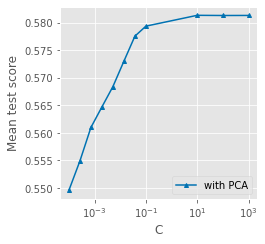

In [31]:
max_index = np.argmax(lr_pca_df.mean_test_score)

fig = plt.figure(figsize = (3.54, 3.54))
plt.xscale('log')
plt.plot(lr_pca_df.param_logisticregression__C, lr_pca_df.mean_test_score, marker = '^', ms = 4, label = 'with PCA')
plt.ylabel('Mean test score')
plt.xlabel('C')
plt.legend()

fig.subplots_adjust(wspace = 0.05)
#fig.savefig('results/roll_pca+lr_grid_results_combined.png')

In [36]:
lr = make_pipeline(StandardScaler(), PCA(whiten=True), LogisticRegression(C=10, max_iter=10000, class_weight='balanced'))
lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA(whiten=True)),
                ('logisticregression',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=10000))])

In [37]:
from joblib import dump, load
#model = load('models/tc_nmf+svr_model_20201012.joblib')
#dump(grid.best_estimator_, 'models/roll_pca+lr_model_{}.joblib'.format(date)) 
dump(lr, 'models/roll_pca+lr_model_{}.joblib'.format(date)) 

['models/roll_pca+lr_model_20201113.joblib']

### Without PCA

In [94]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from dask_ml.model_selection import GridSearchCV
from split import my_group_stratify_shuffle_cv

lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 10000, class_weight = 'balanced'))

param_grid = {'logisticregression__C': np.logspace(-4, -3, 4)}

mycv = my_group_stratify_shuffle_cv(X_train, y_train, groups_train)

grid = GridSearchCV(lr, param_grid = param_grid, cv = mycv, scoring = 'balanced_accuracy', n_jobs = -1)

grid.fit(X_train, y_train)

print("Best score on validation set: {:.2f}".format(grid.best_score_)) 
print("Best parameters: ", grid.best_params_)

Best score on validation set: 0.57
Best parameters:  {'logisticregression__C': 0.001}
CPU times: user 18.2 s, sys: 1.16 s, total: 19.3 s
Wall time: 42.7 s


In [99]:
lr_df = pd.DataFrame(grid.cv_results_)
lr_df.to_csv('results/roll_lr_grid_{}.csv'.format(date))

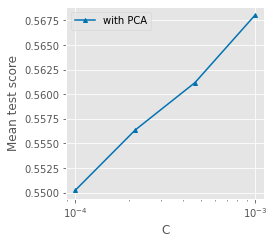

In [100]:
max_index = np.argmax(lr_df.mean_test_score)

fig = plt.figure(figsize = (3.54, 3.54))
plt.xscale('log')
#plt.ylim(0.61, 0.68)
#plt.plot(lr_noPCA_df.param_logisticregression__C, lr_noPCA_df.mean_test_score, marker = 'o', ms = 4, label = 'without PCA')
plt.plot(lr_df.param_logisticregression__C, lr_df.mean_test_score, marker = '^', ms = 4, label = 'with PCA')
#plt.yticks(np.linspace(0.625, 0.675, 3))
plt.ylabel('Mean test score')
plt.xlabel('C')
plt.legend()

#plt.annotate(s = 'Best score = {:.3f}\nC = {}'.format(lr_df.mean_test_score[max_index], lr_df.param_logisticregression__C[max_index]),
#             xy = (lr_df.param_logisticregression__C[max_index], lr_df.mean_test_score[max_index]-.001),
#             xytext = (0.1, 0.625), arrowprops=dict(facecolor='gray', arrowstyle = 'fancy')
#            )
fig.subplots_adjust(wspace = 0.05)
#fig.savefig('results/roll_pca+lr_grid_results_combined.png')

In [101]:
lr = make_pipeline(StandardScaler(), LogisticRegression(C=0.001, max_iter=10000, class_weight='balanced'))
lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=10000))])

In [102]:
from joblib import dump, load
#model = load('models/tc_nmf+svr_model_20201012.joblib')
#dump(grid.best_estimator_, 'models/roll_pca+lr_model_{}.joblib'.format(date)) 
dump(lr, 'models/roll_lr_model_{}.joblib'.format(date)) 

['models/roll_lr_model_20201113.joblib']

### Combined result

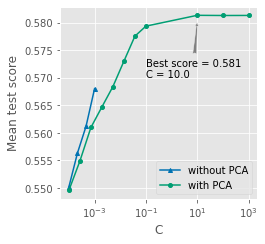

In [111]:
max_index = np.argmax(lr_pca_df.mean_test_score)

fig = plt.figure(figsize = (3.54, 3.54))
plt.xscale('log')
#plt.ylim(0.61, 0.68)
plt.plot(lr_df.param_logisticregression__C, lr_df.mean_test_score, marker = '^', ms = 4, label = 'without PCA')
plt.plot(lr_pca_df.param_logisticregression__C, lr_pca_df.mean_test_score, marker = 'o', ms = 4, label = 'with PCA')
#plt.yticks(np.linspace(0.625, 0.675, 3))
plt.ylabel('Mean test score')
plt.xlabel('C')
plt.legend()

plt.annotate(text = 'Best score = {:.3f}\nC = {}'.format(lr_pca_df.mean_test_score[max_index], lr_pca_df.param_logisticregression__C[max_index]),
             xy = (lr_pca_df.param_logisticregression__C[max_index], lr_pca_df.mean_test_score[max_index]-.001),
             xytext = (0.1, 0.57), arrowprops=dict(facecolor='gray', arrowstyle = 'fancy')
            )
fig.subplots_adjust(wspace = 0.05)
fig.savefig('results/roll_pca+lr_grid_combined_{}.png'.format(date))

For lr with PCA, values of parameter C around 1 cause the server to break.<br>
For lr without PCA, values of parameter C larger than 0.001 cause the server to break already.

## Manual submition
No dask involved. With and without PCA computation in total costs 6 minutes and all parameter C values are executedk, which is way faster than the any dask involved attempts. The models are stored as roll_pca+lr_model_ss_20201113.joblib and roll_lr_model_ss_20201113.joblib. The job log is slurm-20675.txt.

In [3]:
lr_pca_df = pd.read_csv('results/roll_pca+lr_grid_ss_20201113.csv', index_col=0)
lr_df = pd.read_csv('results/roll_lr_grid_ss_20201113.csv', index_col=0)

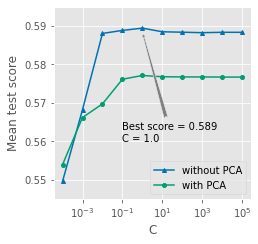

In [10]:
max_index = np.argmax(lr_df.mean_test_score)

fig = plt.figure(figsize = (3.54, 3.54))
plt.xscale('log')
plt.ylim(0.545, 0.595)
plt.plot(lr_df.param_logisticregression__C, lr_df.mean_test_score, marker = '^', ms = 4, label = 'without PCA')
plt.plot(lr_pca_df.param_logisticregression__C, lr_pca_df.mean_test_score, marker = 'o', ms = 4, label = 'with PCA')
#plt.yticks(np.linspace(0.625, 0.675, 3))
plt.ylabel('Mean test score')
plt.xlabel('C')
plt.legend()

plt.annotate(text = 'Best score = {:.3f}\nC = {}'.format(lr_df.mean_test_score[max_index], lr_df.param_logisticregression__C[max_index]),
             xy = (lr_df.param_logisticregression__C[max_index], lr_df.mean_test_score[max_index]-.001),
             xytext = (0.1, 0.56), arrowprops=dict(facecolor='gray', arrowstyle = 'fancy')
            )
fig.subplots_adjust(wspace = 0.05)
fig.savefig('results/roll_pca+lr_grid_ss_combined_{}.png'.format(date))